In [1]:
import os
import numpy as np
from tqdm import tqdm
import math
import matplotlib.pyplot as plt
import skopt
from skopt.space import *
from skopt.utils import use_named_args
from skopt import gp_minimize

In [2]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.autograd import Variable

In [3]:
torch.cuda.is_available()

True

In [4]:
cd = torch.cuda.current_device()
torch.cuda.get_device_name(cd)

'NVIDIA GeForce RTX 3060'

## Load the interpolated spectrum files

### use this block instead ofthe ones above

In [ ]:
dr16qsnr10_dataset_np = np.load('dr16qsnr10_dataset_vae_eval.npy')
dr16qsnr10_errterm_np = np.load('dr16qsnr10_errterm_vae_eval.npy')

normalize dataset

In [7]:
# get max norms of each spectrum
norms = np.max(dr16qsnr10_dataset_np, axis=1)[:,None]
# normalize each of the spectra
dr16qsnr10_dataset_np = dr16qsnr10_dataset_np/norms

normalize error terms

In [8]:
dr16qsnr10_errterm_np = dr16qsnr10_errterm_np/norms # normalize all the flux errors 
ivar = 1/dr16qsnr10_errterm_np**2 # inverse variance

eps = 1./(2e6) # weight cap
data_weights = ivar/(1 + eps*ivar)

subsampled to 1500 elements each spectrum

In [9]:
dr16qsnr10_dataset_np.shape

(21771, 1500)

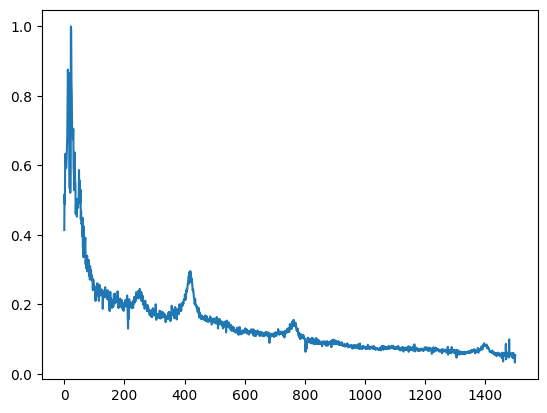

In [10]:
plt.plot(dr16qsnr10_dataset_np[245, :])

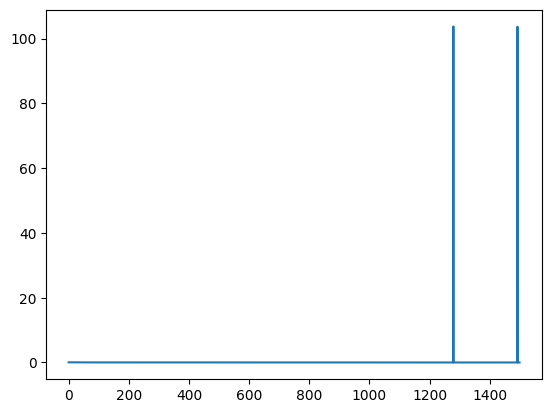

In [11]:
plt.plot(dr16qsnr10_errterm_np[245, :])

## VAE implementation
Import code file `InfoVAE_2.py` \
adapted from: https://github.com/stephenportillo/SDSS-VAE/blob/master/InfoVAE.py

In [12]:
from torch import optim

In [13]:
from InfoVAE_2 import *

#### dataset train/valid setup

In [14]:
spec = dr16qsnr10_dataset_np
weights = data_weights

In [15]:
# train test split - number in each set
trainfrac = 0.75
ntrain = int(spec.shape[0] * trainfrac)
nvalid = spec.shape[0] - ntrain
# number of feature (number of pixel in each spectrum)
nfeat = spec.shape[1]

In [16]:
# splitting the dataset
# make validation set deterministic
np.random.seed(645847)
permutation = np.random.permutation(spec.shape[0])

# indices of train set
trainidx = permutation[0:ntrain]
# validation set indices
valididx = permutation[-1-nvalid:-1]
# train and test sets
trainspec = spec[trainidx,:]
validspec = spec[valididx,:]
trainweig = weights[trainidx,:]
validweig = weights[valididx,:]
# np.savez(tag+'/datasplit.npz', trainidx=trainidx, valididx=valididx)

In [17]:
trainspec.shape

(16328, 1500)

In [18]:
batch_size=64

In [19]:
# torch dataloader for training in batches
# train set
dataloader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(torch.tensor(trainspec, dtype=torch.float32), torch.tensor(trainweig, dtype=torch.float32)),
    batch_size=batch_size,
    shuffle=True)
# valid set
valdloader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(torch.tensor(validspec, dtype=torch.float32), torch.tensor(validweig, dtype=torch.float32)),
    batch_size=nvalid)

#### utility setup

In [20]:
def train(model, optimizer, epoch): #model, optimizer, epoch, min_valid_loss, badepochs
    model.train()
    train_loss = 0
    train_logL = 0
    for batch_idx, data in enumerate(dataloader):
        spectrum, weig = data
        
        optimizer.zero_grad()
        loss, logL, KLD, MMD = model.loss(spectrum, weig, epoch)
        loss.backward()
        train_loss += loss.item()
        train_logL += logL.item()
        optimizer.step()
    train_loss /= len(dataloader.dataset)
    
    with torch.no_grad():
        model.eval()
        valid_loss = 0
        valid_logL = 0
        valid_KLD = 0
        valid_MMD = 0

        for valddata in valdloader:
            spectrum, weig = valddata
            
            loss, logL, KLD, MMD = model.loss(spectrum, weig, epoch)
            valid_loss += loss.item()
            valid_logL += logL.item()
            valid_KLD += KLD.item()
            valid_MMD += MMD.item()
        
        valid_loss /= len(valdloader.dataset)
        valid_logL /= -len(valdloader.dataset)
        valid_KLD  /= len(valdloader.dataset)
        valid_MMD  /= len(valdloader.dataset)
    return valid_loss, valid_logL, valid_KLD, valid_MMD

In [21]:
class EarlyStopper:
    def __init__(self, precision=1e-3, patience=10):
        self.precision = precision
        self.patience = patience
        self.badepochs = 0
        self.min_valid_loss = float('inf')
        
    def step(self, valid_loss):
        if valid_loss < self.min_valid_loss*(1-self.precision):
            self.badepochs = 0
            self.min_valid_loss = valid_loss
        else:
            self.badepochs += 1
        return not (self.badepochs == self.patience)

#### other parameters

In [22]:
# max number of epoches each try
epochs = 200
# number of tries, each with different configuration
n_config = 100
# print logs every this many epoches
log_interval = 5

We optimize the hyperparameters using `skopt`'s `gp_minimize`

In [23]:
# define the space of hyperparameters to search
search_space = list()
search_space.append(Real(2.0, 2.0 ** 6, 'log-uniform', name='lambda'))
# search_space.append(Real(0.0, 0.9, 'uniform', name='alpha'))
# search_space.append(Integer(8, 256, 'log-uniform', base=2, name='layer_1'))
# search_space.append(Integer(8, 128, 'log-uniform', base=2, name='layer_2'))
# search_space.append(Integer(0, 2, 'uniform', name='pre_latent_depth'))
# search_space.append(Integer(0, 7, 'uniform', name='pre_latent_width'))

In [24]:
# arrays to record the results
results = {}

In [25]:
# the folder to store the saved neural networks in
tag = 'VAE_dr16qsnr10_hypersearch_2024-12-16d'

#### train with hyperparam optimization

In [26]:
# number of latent dimiensions is a hyperparameter independent from others
ncode = None
# set it to the following values:
# ncode_vals = [9, 12, 15]
ncode_vals = [3, 6, 12, 15]

In [27]:
# define the function used to evaluate a given configuration
@use_named_args(search_space)
def evaluate_model(**params):
    # unpack the hyperparameters
    lambd = params['lambda']
    # alpha = params['alpha']
    alpha = 0.0
    nhidden1 = 256
    nhidden2 = 128
    # pre_depth = params['pre_latent_depth']
    pre_depth = 0
    # pre_width = params['pre_latent_width']
    # the network topology (number of pre-depth layers is 1 hyperparam)
    nhidden = [nhidden1, nhidden2] + [ncode,] * pre_depth

    # these are not changed
    # dropout (not used?)
    dropout = 0   #0.9*np.random.uniform()
    dfac = 1./(1.-dropout)

	# create model with specific hyperparameters
    # print('config: alpha = %0.1f, lambda = %0.1f; hidden layers with %s, nodes' % (alpha, lambd, str(nhidden)))
    print('config: alpha = %0.1f, lambda = %0.1f; hidden layers with %s, nodes' % (alpha, lambd, str(nhidden)))

    # create model
    model = InfoVAE(alpha=alpha, lambd=lambd, nfeat=nfeat, nhidden=nhidden, ncode=ncode, dropout=dropout)

    # optimizer and auxilary components for the model
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', verbose=True, patience=5)
    stopper = EarlyStopper(patience=10)

    # the metric we are optimizing on is validation loss
    res_valid_loss = None

    # train many epoches
    for epoch in range(1, epochs + 1):
        # train call
        valid_loss, valid_logL, valid_KLD, valid_MMD = train(model, optimizer, epoch)
        
        if epoch % log_interval == 0:
            print('====> Epoch: {} VALIDATION Loss: {:.2e} logL: {:.2e} KL: {:.2e} MMD: {:.2e}'.format(
                  epoch, valid_loss, valid_logL, valid_KLD, valid_MMD))

        # scheduler to update weights
        scheduler.step(valid_loss)
        # early stopper
        if (not stopper.step(valid_loss)) or (epoch == epochs):
            print('Stopping')
            print('====> Epoch: {} VALIDATION Loss: {:.2e} logL: {:.2e} KL: {:.2e} MMD: {:.2e}'.format(
                  epoch, valid_loss, valid_logL, valid_KLD, valid_MMD))
            model.MSE = -valid_logL
            model.KLD = valid_KLD
            model.MMD = valid_MMD
            # mdl_MSE[i] = model.MSE
            # mdl_KLD[i] = model.KLD
            # mdl_MMD[i] = model.MMD
            
            res_valid_loss = float(valid_loss)
            
            # save model
            torch.save(model, tag+'/VAE_%ifeat_lambd-%f_alpha-%f_nhidden-%s.pth' % (ncode, lambd, alpha, '-'.join([str(i) for i in nhidden])))
            break

	# minimize valid loss
    return res_valid_loss

In [28]:
n_calls = 10
opti_results = []

# perform optimization on each of the latent dimension values
for nc in ncode_vals:
    # ncode is that variable above (global variable)
    ncode = nc

    # run optimization
    result = gp_minimize(evaluate_model, search_space, n_calls=n_calls)
    opti_results.append(result)
    # summarizing finding:
    print('Best Validation loss: %.3f' % (result.fun))
    print('Best Parameters: %s' % (result.x))

config: alpha = 0.0, lambda = 20.5; hidden layers with [256, 128], nodes


C:\Python310\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


====> Epoch: 5 VALIDATION Loss: 1.89e+04 logL: -1.89e+04 KL: 4.95e+00 MMD: 1.39e+00
====> Epoch: 10 VALIDATION Loss: 1.45e+04 logL: -1.45e+04 KL: 7.07e+00 MMD: 1.39e+00
====> Epoch: 15 VALIDATION Loss: 1.23e+04 logL: -1.22e+04 KL: 8.58e+00 MMD: 1.41e+00
====> Epoch: 20 VALIDATION Loss: 1.15e+04 logL: -1.15e+04 KL: 9.65e+00 MMD: 1.24e+00
====> Epoch: 25 VALIDATION Loss: 1.04e+04 logL: -1.04e+04 KL: 1.15e+01 MMD: 1.24e+00
====> Epoch: 30 VALIDATION Loss: 1.01e+04 logL: -1.00e+04 KL: 1.30e+01 MMD: 1.10e+00
====> Epoch: 35 VALIDATION Loss: 9.81e+03 logL: -9.78e+03 KL: 1.42e+01 MMD: 1.10e+00
====> Epoch: 40 VALIDATION Loss: 9.63e+03 logL: -9.59e+03 KL: 1.54e+01 MMD: 1.02e+00
====> Epoch: 45 VALIDATION Loss: 9.52e+03 logL: -9.48e+03 KL: 1.66e+01 MMD: 1.03e+00
====> Epoch: 50 VALIDATION Loss: 9.45e+03 logL: -9.41e+03 KL: 1.76e+01 MMD: 9.37e-01
====> Epoch: 55 VALIDATION Loss: 9.36e+03 logL: -9.32e+03 KL: 1.85e+01 MMD: 1.05e+00
====> Epoch: 60 VALIDATION Loss: 8.97e+03 logL: -8.94e+03 KL: 1.87

C:\Python310\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


====> Epoch: 5 VALIDATION Loss: 1.77e+04 logL: -1.77e+04 KL: 9.61e+00 MMD: 2.96e+00
====> Epoch: 10 VALIDATION Loss: 1.34e+04 logL: -1.34e+04 KL: 1.36e+01 MMD: 3.29e+00
====> Epoch: 15 VALIDATION Loss: 1.17e+04 logL: -1.17e+04 KL: 1.58e+01 MMD: 3.30e+00
====> Epoch: 20 VALIDATION Loss: 1.05e+04 logL: -1.05e+04 KL: 1.85e+01 MMD: 3.27e+00
====> Epoch: 25 VALIDATION Loss: 8.96e+03 logL: -8.92e+03 KL: 2.26e+01 MMD: 2.98e+00
====> Epoch: 30 VALIDATION Loss: 7.97e+03 logL: -7.92e+03 KL: 2.64e+01 MMD: 2.91e+00
====> Epoch: 35 VALIDATION Loss: 7.60e+03 logL: -7.55e+03 KL: 2.93e+01 MMD: 2.75e+00
====> Epoch: 40 VALIDATION Loss: 7.46e+03 logL: -7.42e+03 KL: 3.17e+01 MMD: 2.76e+00
====> Epoch: 45 VALIDATION Loss: 7.35e+03 logL: -7.29e+03 KL: 3.38e+01 MMD: 2.84e+00
====> Epoch: 50 VALIDATION Loss: 7.22e+03 logL: -7.17e+03 KL: 3.56e+01 MMD: 2.82e+00
====> Epoch: 55 VALIDATION Loss: 7.08e+03 logL: -7.03e+03 KL: 3.68e+01 MMD: 2.54e+00
====> Epoch: 60 VALIDATION Loss: 7.04e+03 logL: -6.99e+03 KL: 3.73

C:\Python310\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


====> Epoch: 5 VALIDATION Loss: 1.74e+04 logL: -1.74e+04 KL: 1.47e+01 MMD: 4.88e+00
====> Epoch: 10 VALIDATION Loss: 1.34e+04 logL: -1.34e+04 KL: 2.08e+01 MMD: 6.01e+00
====> Epoch: 15 VALIDATION Loss: 1.21e+04 logL: -1.21e+04 KL: 2.54e+01 MMD: 6.65e+00
====> Epoch: 20 VALIDATION Loss: 1.06e+04 logL: -1.06e+04 KL: 3.15e+01 MMD: 6.52e+00
====> Epoch: 25 VALIDATION Loss: 9.10e+03 logL: -9.05e+03 KL: 3.88e+01 MMD: 6.49e+00
====> Epoch: 30 VALIDATION Loss: 7.80e+03 logL: -7.74e+03 KL: 4.66e+01 MMD: 5.94e+00
====> Epoch: 35 VALIDATION Loss: 7.24e+03 logL: -7.17e+03 KL: 5.40e+01 MMD: 5.68e+00
====> Epoch: 40 VALIDATION Loss: 6.91e+03 logL: -6.84e+03 KL: 5.99e+01 MMD: 5.49e+00
====> Epoch: 45 VALIDATION Loss: 6.59e+03 logL: -6.51e+03 KL: 6.50e+01 MMD: 5.40e+00
====> Epoch: 50 VALIDATION Loss: 6.55e+03 logL: -6.47e+03 KL: 6.91e+01 MMD: 5.20e+00
====> Epoch: 55 VALIDATION Loss: 6.50e+03 logL: -6.42e+03 KL: 7.15e+01 MMD: 4.97e+00
====> Epoch: 60 VALIDATION Loss: 6.35e+03 logL: -6.27e+03 KL: 7.30

C:\Python310\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


====> Epoch: 5 VALIDATION Loss: 1.79e+04 logL: -1.78e+04 KL: 1.85e+01 MMD: 5.88e+00
====> Epoch: 10 VALIDATION Loss: 1.35e+04 logL: -1.33e+04 KL: 2.79e+01 MMD: 7.31e+00
====> Epoch: 15 VALIDATION Loss: 1.23e+04 logL: -1.22e+04 KL: 3.41e+01 MMD: 7.55e+00
====> Epoch: 20 VALIDATION Loss: 1.02e+04 logL: -1.00e+04 KL: 4.10e+01 MMD: 7.55e+00
====> Epoch: 25 VALIDATION Loss: 8.74e+03 logL: -8.57e+03 KL: 4.88e+01 MMD: 7.07e+00
====> Epoch: 30 VALIDATION Loss: 7.89e+03 logL: -7.72e+03 KL: 5.70e+01 MMD: 6.80e+00
====> Epoch: 35 VALIDATION Loss: 7.23e+03 logL: -7.06e+03 KL: 6.40e+01 MMD: 6.58e+00
====> Epoch: 40 VALIDATION Loss: 7.09e+03 logL: -6.92e+03 KL: 7.05e+01 MMD: 6.21e+00
====> Epoch: 45 VALIDATION Loss: 6.89e+03 logL: -6.72e+03 KL: 7.62e+01 MMD: 5.94e+00
====> Epoch: 50 VALIDATION Loss: 6.57e+03 logL: -6.39e+03 KL: 8.07e+01 MMD: 5.74e+00
====> Epoch: 55 VALIDATION Loss: 6.45e+03 logL: -6.27e+03 KL: 8.39e+01 MMD: 5.69e+00
====> Epoch: 60 VALIDATION Loss: 6.36e+03 logL: -6.18e+03 KL: 8.49

In [29]:
print('Best Validation loss: %.3f' % (result.fun))
print('Best Parameters: %s' % (result.x))

Best Validation loss: 5701.087
Best Parameters: [7.823182203193062]


In [30]:
for i in range(len(ncode_vals)):
    print('Number of latent dimensions: ', ncode_vals[i])
    # summarizing finding:
    print('Best Validation loss: %.3f' % (opti_results[i].fun))
    print('Best Parameters: %s' % (opti_results[i].x))

Number of latent dimensions:  3
Best Validation loss: 8519.655
Best Parameters: [5.043310624057961]
Number of latent dimensions:  6
Best Validation loss: 6327.255
Best Parameters: [6.059668283296925]
Number of latent dimensions:  12
Best Validation loss: 5757.527
Best Parameters: [8.389687114068746]
Number of latent dimensions:  15
Best Validation loss: 5701.087
Best Parameters: [7.823182203193062]
